# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation**

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer



device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x


# Se crea una nueva clase doonde el positional_encoding se define como un parámetro de la red
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.positional_encoding



# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


Dispositivo:  cuda
Torch version:  2.5.0+cu121


# Transformer Encoder

In [13]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model
>
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads
    Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


Se contruye la clase VisionTransformer usando las clases anteriormente mostradas, la creada en el TP1 y se tiene en cuenta las parámetros de entrada:

        - img_size
        - patch_size
        - embed_dim
        - num_heads
        - ff_dim
        - num_layers
        - dropout
        - batch_first

In [14]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size: int, patch_size: int,  embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout: float, batch_first: bool):
        super(VisionTransformer, self).__init__()
        # El número de parches de obtiene a partir de img_size y patch_size
        self.num_patches = (img_size // patch_size) ** 2
        # Instanciar patch_embedding
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels = 3, embed_dim = embed_dim)
        # Instanciar positional_encoding
        self.positional_encoding = PositionalEncodingLearned(self.num_patches, embed_dim = embed_dim)
        # Instanciar transformer_encoder
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        # Capa de salida que al usar CIFAR10 se tienen 10 clases de salida
        self.mlp_head = nn.Linear(embed_dim, 10)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1) #x[:, 0]

        return self.mlp_head(x)

In [15]:
# Tamaño del directorio
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


In [16]:
# Contador de la cantidad de parámetros del modelo
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000


In [17]:
# Evaluar modelo obteniendo las métricas de accuracy, precision, recall, f1
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

In [18]:
# Visualizar una cantidad de imágenes igual a num_images, para comparar su
# etiqueta real con la predicha
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]


Cómo dataset se usa CIFAR10, por lo que se tiene 10 clases de salida.

In [19]:
folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


**Se va a probar las primeras epochs para comprobar cuál modelo tiene parámetros más adecuados. Se hace esto debido a que se tiene capacidad de cómputo limitada al utilizar google colab.**

**De todo lo modelos que se mostrarán a continuación, aquellos que tengan la indicación de "(prueba)" en el título, quiere decir que el fin era probar las métricas para pocas epochs.**

**Por otro lado, aquel modelo que no contenga la indicación de "(prueba)" quiere decir que es el modelo seleccionado, el cual se usará sin data augmentation adicional y luego incluyendo más data augmentation para poder realizar una comparación.**

# Modelo 0 (prueba)

Se usan los parámetros más comunes para el ViT.

In [ ]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Parámetros del modelo
num_epochs = 3

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_0 = VisionTransformer(
    img_size= 32,   # Tamaño de imágenes de CIFAR10
    patch_size= 16, # Tamaño clásico del ViT
    embed_dim= 768,
    num_heads= 12,
    ff_dim= 3072,
    num_layers= 12,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_0.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_0.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_0 = model_0.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 1.0718e-02, -3.1830e-02,  1.9160e-02,  ..., -1.4707e-03,
           -3.3541e-02,  2.7635e-02],
          [ 3.4250e-02, -2.1891e-02, -2.1521e-02,  ...,  5.9500e-04,
            3.2446e-02,  2.9699e-02],
          [-3.3427e-02, -2.4160e-02, -3.3650e-02,  ..., -3.3249e-02,
            6.2884e-03,  1.6095e-02],
          ...,
          [ 6.1275e-03, -1.1457e-02,  6.6182e-03,  ..., -1.6185e-02,
           -1.3743e-03,  2.1814e-02],
          [-3.9797e-03,  2.8164e-02,  3.2422e-02,  ..., -3.6008e-02,
           -3.2125e-02, -3.5508e-02],
          [-2.2834e-02,  3.4937e-02, -1.9669e-02,  ..., -2.6207e-02,
            2.5321e-02, -1.1277e-02]],

         [[-2.6855e-02, -2.3335e-02, -2.1942e-02,  ...,  3.0757e-02,
           -4.3086e-03, -1.4652e-02],
          [-1.4405e-02,  3.2444e-02,  3.2650e-02,  ...,  3.2350e-02,
            2.0390e-02,  8.5635e-03],
          [ 2.1230e-02,  1.2955e-02, -1.4974e-02,  ...,  3.3899e-02,
           -

In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_0)))

Número de parámetros: 85.55 millones


In [ ]:
trainer = Trainer(model_0, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=False)

loss 2.33784: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_0, test_loader)

100%|██████████| 20/20 [00:10<00:00,  1.99it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


  0%|          | 0/20 [00:00<?, ?it/s]


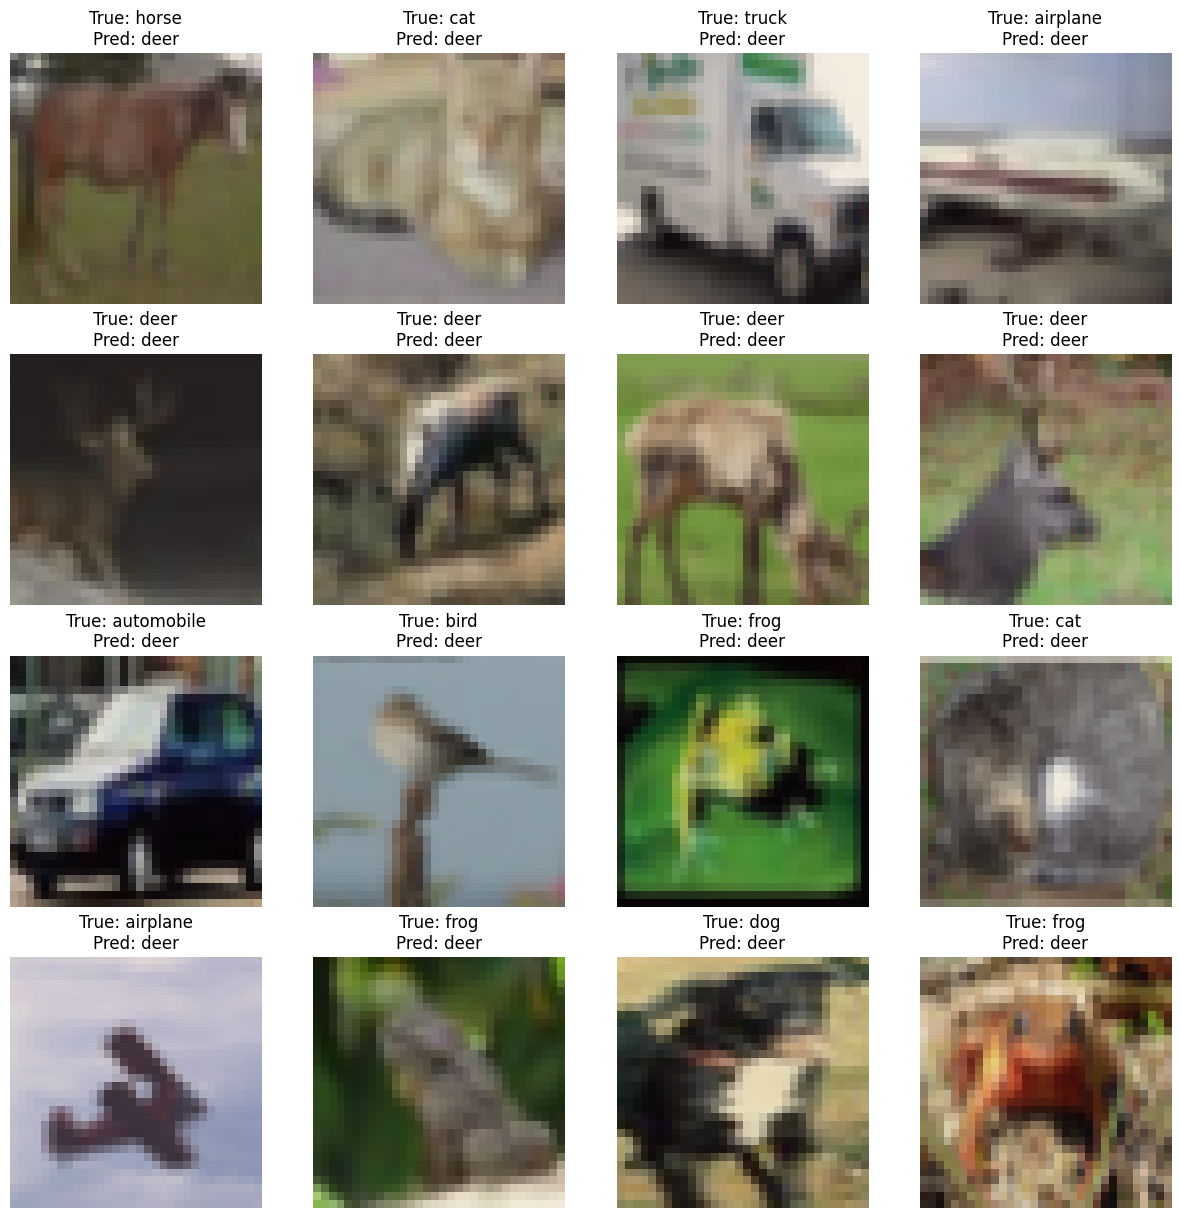

In [ ]:
visualize_classification(model_0, test_loader, class_names, num_images=16)
plt.show()


Usando los parámetros planteados en el notebook y en el paper, entre los cuales se tiene img_size de 32x32 por tratarse de CIFAR10 y el patch_size de 16 por como se considera por defecto en el vision tranformer dan un resultado muy malo en las métricas. El patch_size es muy grande para las imágenes, por lo que no le permite aprender sobre los detalles de estas.

# Modelo 1 (prueba): menor patch_size y embed_dim
- patch_size: 16 -> 8
- embed_dim: 768 -> 192

In [ ]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Parámetros del modelo
num_epochs = 3

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 32,   # Tamaño de imágenes de CIFAR10
    patch_size= 8,
    embed_dim= 192,
    num_heads= 12,
    ff_dim= 3072,
    num_layers= 12,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_1 = model_1.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0445, -0.0400, -0.0430,  ...,  0.0660,  0.0281, -0.0505],
          [ 0.0437,  0.0706,  0.0194,  ..., -0.0436, -0.0615,  0.0088],
          [ 0.0097,  0.0535, -0.0108,  ..., -0.0420,  0.0174, -0.0429],
          ...,
          [ 0.0571,  0.0392,  0.0179,  ...,  0.0304, -0.0253, -0.0704],
          [-0.0247, -0.0565,  0.0146,  ...,  0.0476,  0.0187,  0.0546],
          [-0.0683, -0.0267, -0.0657,  ...,  0.0228, -0.0564,  0.0253]],

         [[ 0.0347, -0.0132,  0.0594,  ...,  0.0653, -0.0131, -0.0383],
          [-0.0301,  0.0527,  0.0632,  ..., -0.0577,  0.0312, -0.0103],
          [ 0.0026,  0.0426,  0.0602,  ...,  0.0560, -0.0444,  0.0626],
          ...,
          [-0.0427, -0.0083,  0.0125,  ..., -0.0545,  0.0292,  0.0608],
          [ 0.0340, -0.0183, -0.0178,  ...,  0.0150,  0.0230, -0.0285],
          [-0.0595, -0.0280,  0.0433,  ..., -0.0143, -0.0513,  0.0619]],

         [[-0.0149,  0.0240, -0.0701,  ...,  0.0420, -0.

In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 15.97 millones


In [ ]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 2.30708: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


  0%|          | 0/20 [00:00<?, ?it/s]


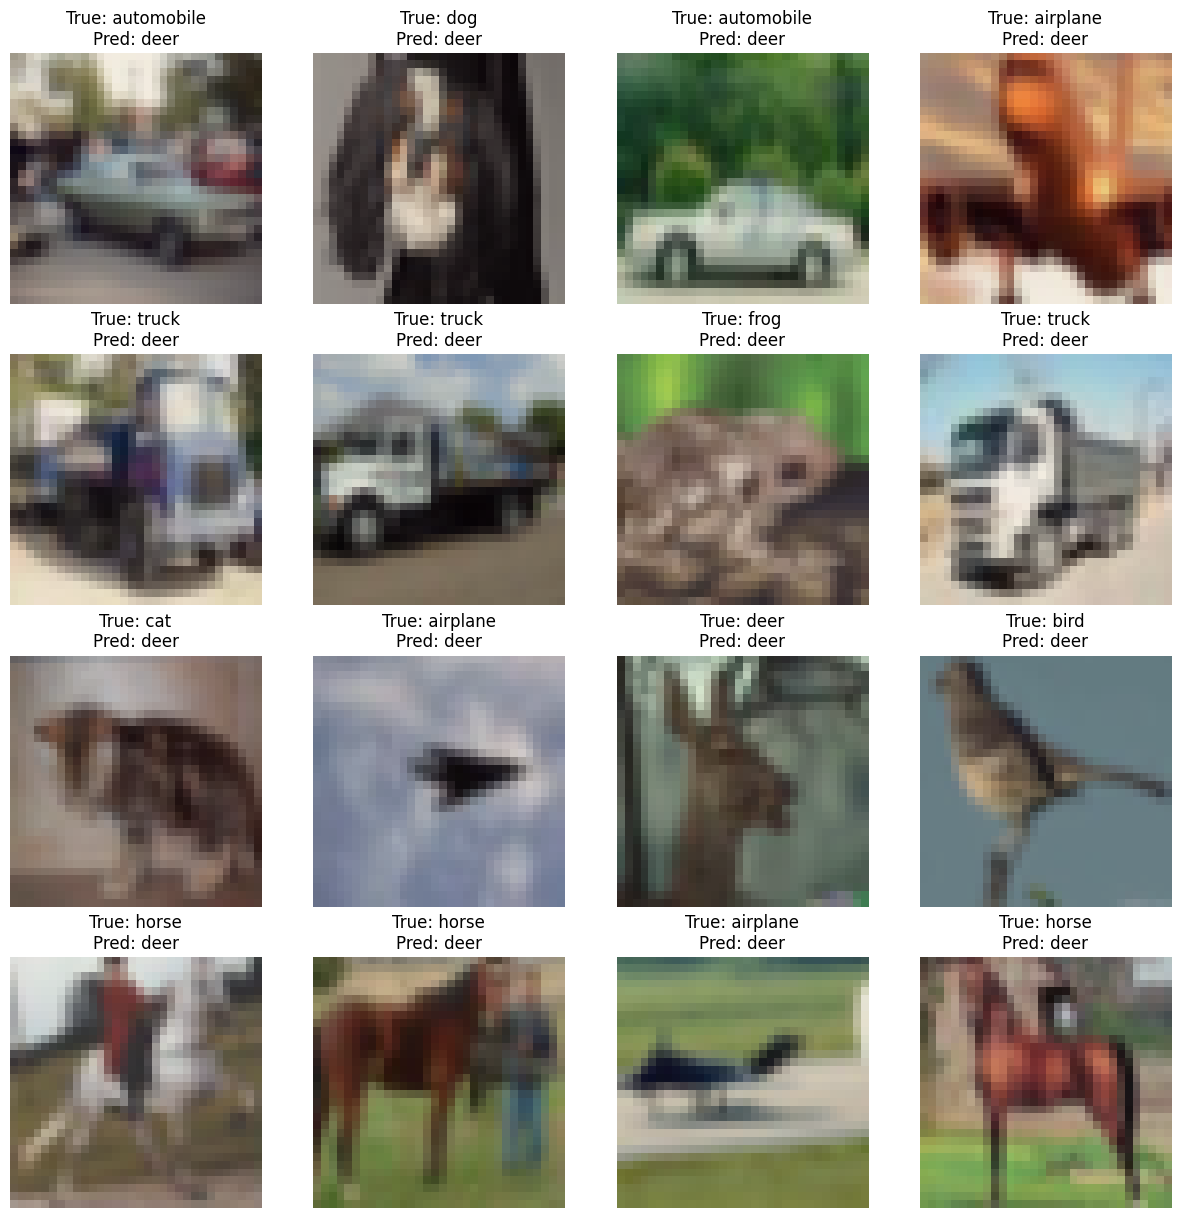

In [ ]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()


La métricas fueron muy bajas, pero se tiene una leve mejora en la pérdida al disminuir el tamaño del patch, lo cuál es lógico debido a que se puede separa en porciones más pequeñas las imágenes. La red neuronal está aprendiendo. Al diminuir embed_dim la cantidad de parámetros disminuyó considerablemente. El otro problema que se observó fue que al diminuir por debajo de 8 el tamaño del patch se quedaba sin memoria y no podía entrenar.

# Modelo 2 (prueba): menor patch_size y batch_size

- patch_size: 8 -> 4
- batch_size: 512 -> 256

Se usan los parámetros más comunes de un ViT de tamaño pequeño, pero que al ser usado en datasets grandes, estos pueden llegar a ser un poco grandes para CIFAR-10. Se prueba como se comporta durante el entrenamiento de 10 epochs.

In [8]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Parámetros del modelo
num_epochs = 10

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_0 = VisionTransformer(
    img_size= 32,   # Tamaño de imágenes de CIFAR10
    patch_size= 4,
    embed_dim= 768,
    num_heads= 12,
    ff_dim= 3072,
    num_layers= 12,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_0.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_0.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_0 = model_0.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[-2.1968e-02, -7.5192e-02,  1.1175e-01, -1.1706e-01],
          [-1.3428e-01, -8.6749e-03, -1.2150e-01,  2.7611e-02],
          [ 7.5480e-02, -3.6576e-02,  5.2725e-02,  7.7772e-02],
          [-7.9405e-02, -9.0453e-02,  1.1119e-01, -1.0608e-01]],

         [[-3.9314e-02, -1.1561e-01,  4.5105e-02, -5.5827e-02],
          [ 1.3306e-01,  1.0804e-01,  5.6946e-02,  5.3330e-03],
          [-3.4027e-02,  6.6162e-02,  1.3644e-02,  1.8842e-02],
          [ 6.6075e-02, -1.3830e-01,  4.5591e-02,  5.1792e-02]],

         [[-4.4283e-02,  7.9123e-02,  3.3305e-02, -3.5026e-02],
          [-1.4276e-01, -1.6150e-02,  4.2869e-02,  6.1876e-02],
          [ 1.0847e-01,  1.7811e-02,  1.3111e-01, -1.1167e-01],
          [ 1.0368e-01,  4.7416e-02, -6.9174e-02, -5.5854e-02]]],


        [[[-1.1455e-01, -6.4506e-02,  8.3431e-02,  7.7085e-02],
          [-5.1527e-02,  7.5499e-02, -8.9877e-02,  7.8721e-02],
          [-2.4720e-02, -1.4352e-01, -1.7423e-03, 

In [10]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_0)))

Número de parámetros: 85.05 millones


In [11]:
trainer = Trainer(model_0, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 2.30371:   1%|          | 2/196 [00:10<16:35,  5.13s/it]


KeyboardInterrupt: 

Al cambiar diminuir el valor de patch_size aún más, conservando los parámetros clásicos, se necesitó de una gran cantidad de RAM de GPU, por lo que se tuvo que disminuir el batch_size de los dataloaders de 512 a 256. Este entrenamiento llevó una gran cantidad de tiempo en tan solo 3 epochs (41min) por lo que se tuvo que interrumpir para ahorrar recursos. No se tuvo una mejora considerable con disminuir aún más el tamaño del patch_size.

Como el dataset de CIFAR-10 es más pequeño en comparación con los que se entrenó a ViT para los benchmark, se tendrán que disminuir el valor de los parámetros.

# Modelo 3 (prueba): transform Resize
- Transform Resize: 32x32 a 64x64

In [ ]:

# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Parámetros del modelo
num_epochs = 3

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 64,
    patch_size= 16,
    embed_dim= 768,
    num_heads= 12,
    ff_dim= 3072,
    num_layers= 12,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_1 = model_1.to(device)


#try:
#    model = torch.compile(model)
#except Exception as e:
#    print("Se produjo error durante la compilación:", e)


Parametros del modelo: [Parameter containing:
tensor([[[[ 2.1211e-02, -1.6705e-02,  7.4870e-04,  ..., -3.6009e-02,
            9.7034e-03, -5.8201e-03],
          [ 1.6243e-02, -3.5377e-03, -9.4743e-03,  ..., -1.7789e-02,
           -1.6930e-02, -1.4385e-02],
          [-1.9324e-02,  7.4860e-03, -6.9646e-03,  ..., -2.6908e-02,
           -2.2368e-02,  2.4237e-02],
          ...,
          [ 3.1627e-02,  7.1121e-03, -2.0497e-02,  ..., -1.1324e-02,
            1.7148e-02, -3.2797e-02],
          [ 1.3542e-02,  1.1816e-02,  1.1067e-02,  ...,  8.9729e-03,
           -7.0537e-03,  5.8957e-03],
          [-2.4357e-02, -3.5861e-02,  1.9959e-02,  ...,  5.5202e-03,
           -1.6974e-02, -3.5340e-02]],

         [[-2.4042e-02,  4.7936e-03,  3.0578e-02,  ...,  2.4727e-02,
           -1.6385e-02, -5.0164e-03],
          [-2.7814e-02, -1.3365e-02, -8.3464e-03,  ..., -9.9057e-04,
            2.6807e-02, -2.1754e-02],
          [ 3.1463e-02, -3.0010e-02,  9.9766e-03,  ..., -3.5894e-02,
           -

In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 85.56 millones


In [ ]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

    #scheduler.step()

loss 2.32599: 100%|██████████| 98/98 [03:48<00:00,  2.33s/it]


In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


In [ ]:
train_dataset.data[0].shape

(32, 32, 3)

  0%|          | 0/20 [00:00<?, ?it/s]


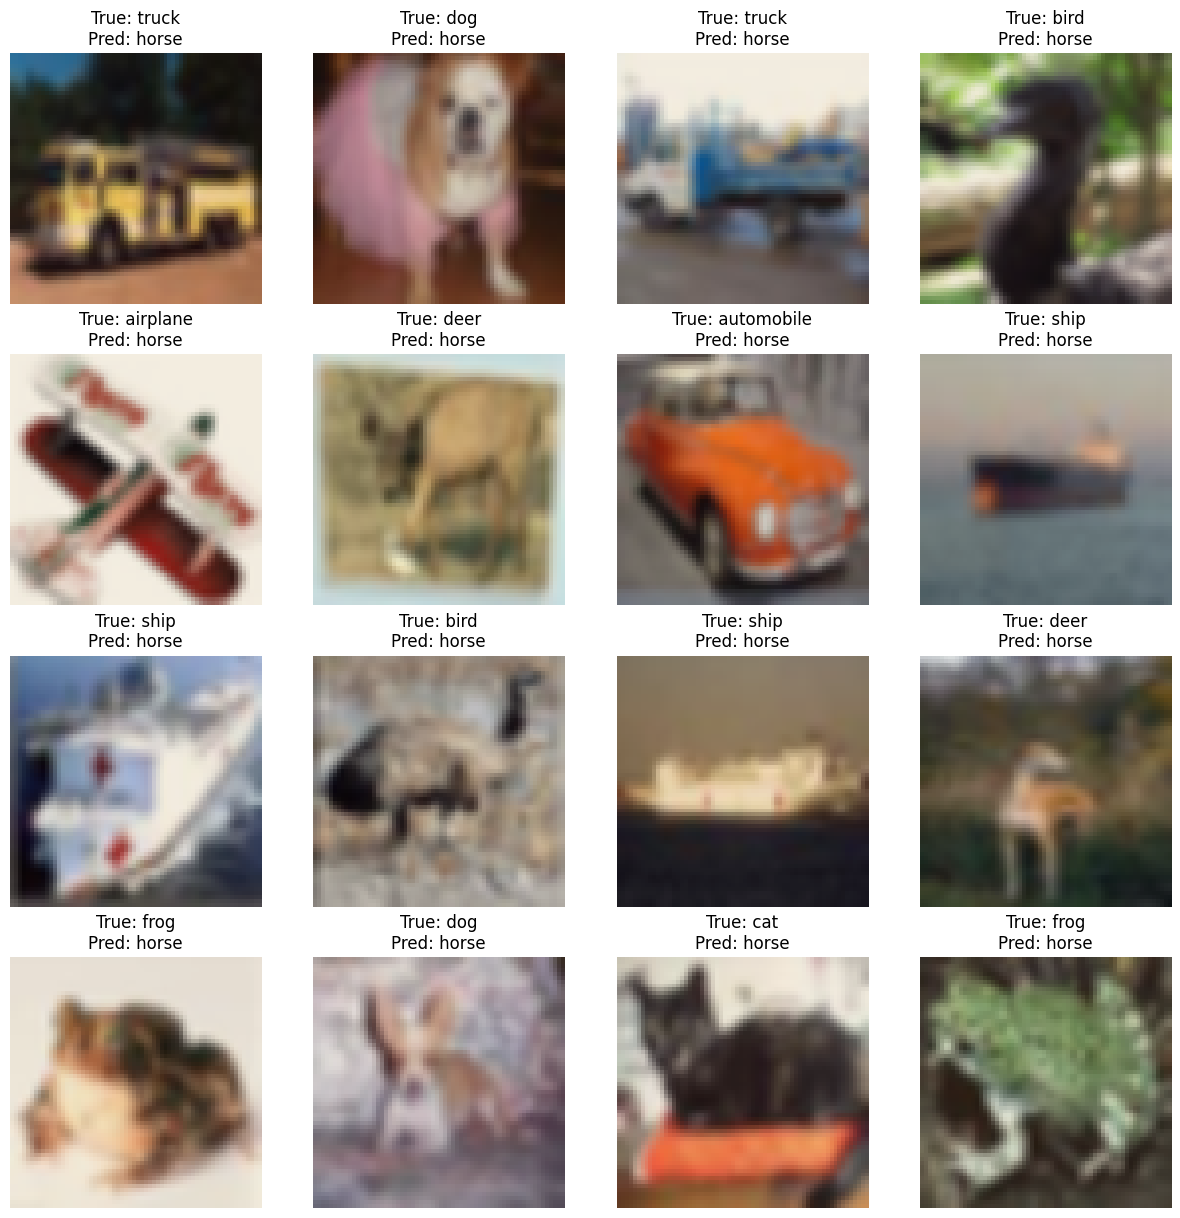

In [ ]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()


Se cambió en "transform" el size de las imágenes para hacerlas de 64x64 pero aún así las métricas no fueron buenas, el tamaño de los patch quedó en 16 como le modelo clásico. Se tuve una pequeña mejora en el entrenamiento en cuanto al loss pero no es considerable. Aumentar aún más el tamaño de las imágenes conllevaría a una disminución del batch_size ya que sino requeriría demasiada RAM de GPU.

# Modelo 4 (prueba): transform Resize a 48x48 y disminución de parámetros
 - Transform Resize: 64x64 -> 48x48
 - patch_size: 16 -> 8
 - embed_dim: 768 -> 192
 - batch_size: 512 -> 128

In [ ]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Parámetros del modelo
num_epochs = 3

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 48,
    patch_size= 8,
    embed_dim= 192,
    num_heads= 12,
    ff_dim= 3072,
    num_layers= 12,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_1 = model_1.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[-0.0207, -0.0377,  0.0061,  ...,  0.0162, -0.0580, -0.0116],
          [-0.0081, -0.0475,  0.0503,  ...,  0.0680,  0.0393, -0.0529],
          [-0.0085,  0.0511,  0.0377,  ..., -0.0268, -0.0642,  0.0014],
          ...,
          [ 0.0268, -0.0216,  0.0006,  ...,  0.0675, -0.0411,  0.0190],
          [ 0.0521,  0.0127,  0.0702,  ...,  0.0179,  0.0382, -0.0538],
          [-0.0469,  0.0608,  0.0256,  ..., -0.0707, -0.0393,  0.0115]],

         [[ 0.0493,  0.0266,  0.0625,  ..., -0.0595, -0.0558, -0.0469],
          [ 0.0551,  0.0704, -0.0379,  ...,  0.0083, -0.0612,  0.0070],
          [ 0.0091,  0.0698,  0.0217,  ..., -0.0621, -0.0225, -0.0249],
          ...,
          [-0.0545,  0.0596, -0.0644,  ...,  0.0311, -0.0267, -0.0641],
          [-0.0087, -0.0438,  0.0363,  ...,  0.0561,  0.0688, -0.0212],
          [ 0.0357, -0.0231, -0.0317,  ..., -0.0083, -0.0013, -0.0066]],

         [[-0.0079, -0.0401,  0.0404,  ..., -0.0398, -0.

In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 15.98 millones


In [ ]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 2.29971: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)

100%|██████████| 79/79 [00:11<00:00,  6.66it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


  0%|          | 0/79 [00:00<?, ?it/s]


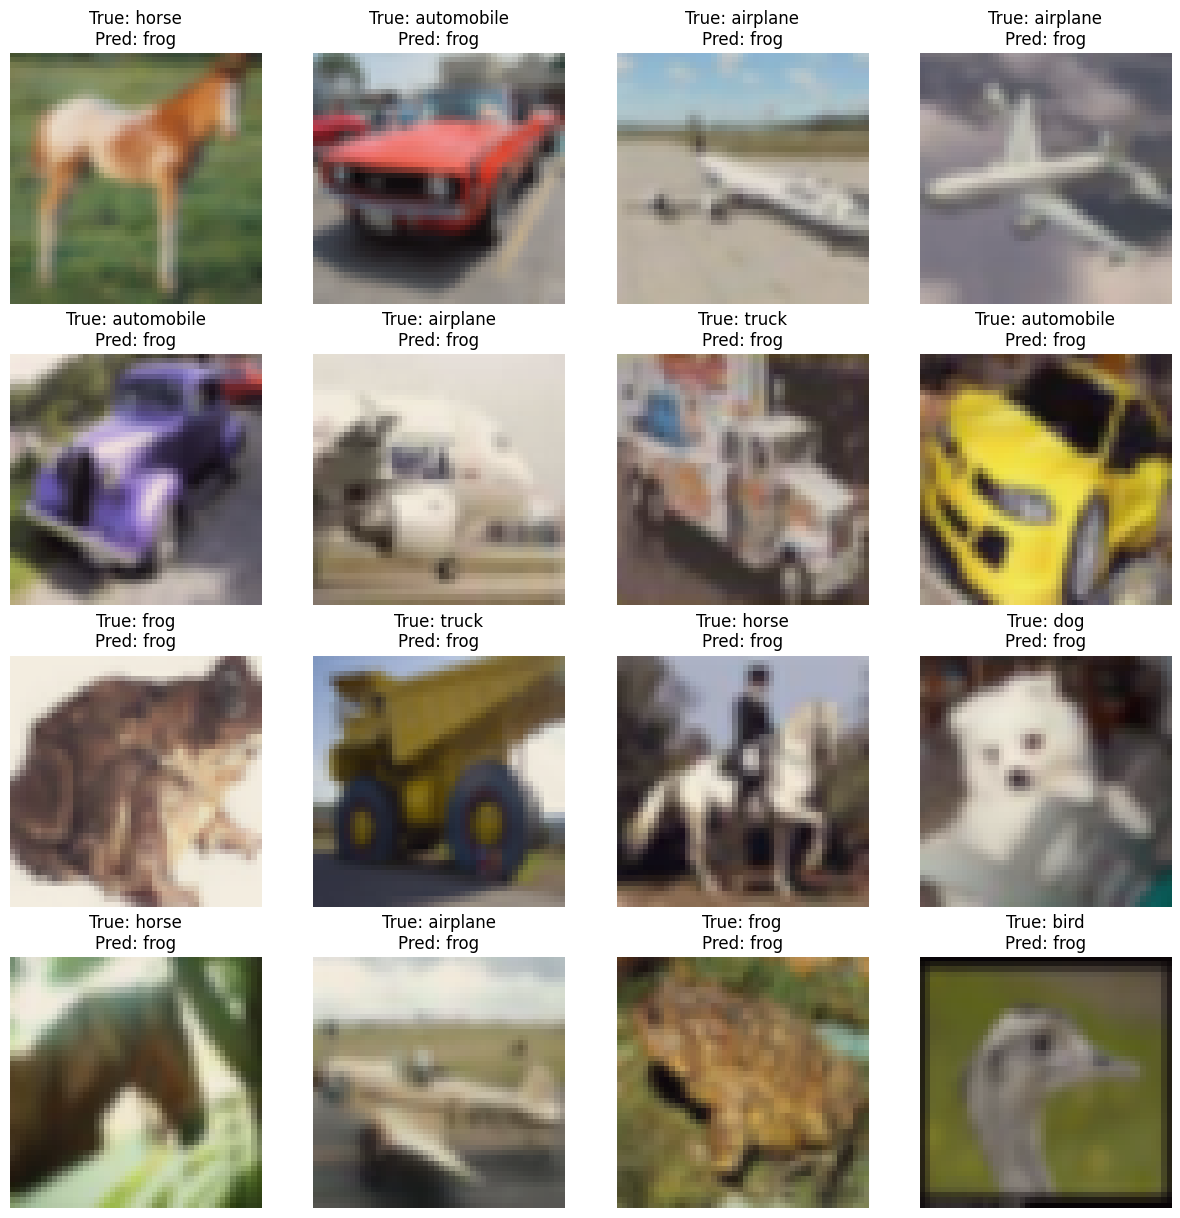

In [ ]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()

Se usó un patch size de 8, se le hizo data transform para tener un tamaño mayor de la imagen pero se quedaba sin memoria al entrenar, por lo que se tuvo que disminuir el batch_size a 128. Las métricas no mejoraron mucho, solo un poco la loss, por lo que el modelo el modelo estaba aprendiendo lentamente.

# Modelo 5 (prueba): diminución de los parámetros
- patch_size: 8 -> 4
- embed_dim: 192 -> 48
- num_heads: 12 -> 4
- ff_dim: 3072 -> 1024
- num_layers: 12 -> 4
    

In [ ]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Parámetros del modelo
num_epochs = 3

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 32,   # Tamaño de imágenes de CIFAR10
    patch_size= 4,
    embed_dim= 48,
    num_heads= 4,
    ff_dim= 1024,
    num_layers= 4,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_1 = model_1.to(device)

Parametros del modelo: [Parameter containing:
tensor([[[[ 0.1407, -0.0948,  0.1320,  0.1197],
          [ 0.0225, -0.0242, -0.1431,  0.0902],
          [-0.0369,  0.0769, -0.0877,  0.0397],
          [-0.0366,  0.0685, -0.1420,  0.0420]],

         [[ 0.0606,  0.0978, -0.0895,  0.1411],
          [-0.0311, -0.0235, -0.0920, -0.0347],
          [-0.0120, -0.0357, -0.0483,  0.0904],
          [ 0.0186, -0.1107,  0.0433,  0.1034]],

         [[ 0.1177,  0.0893,  0.1280, -0.0582],
          [ 0.0048, -0.0127,  0.0052, -0.0174],
          [-0.1162, -0.1430,  0.1008,  0.1427],
          [-0.1208,  0.1233, -0.0022, -0.1164]]],


        [[[-0.1357, -0.0331,  0.1293, -0.0475],
          [ 0.0541, -0.1322,  0.0742, -0.1156],
          [ 0.1013,  0.1044, -0.0530,  0.0133],
          [-0.0907,  0.1064, -0.0927, -0.0907]],

         [[ 0.0855, -0.1170, -0.0890,  0.0303],
          [ 0.0722,  0.0168, -0.0946, -0.1355],
          [-0.0430,  0.0909, -0.0072, -0.0488],
          [-0.1011,  0.0116,  0.

In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 0.44 millones


In [ ]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 2.07746: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)

100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.24
Precision: 0.23
Recall: 0.24
F1 score: 0.23


  0%|          | 0/20 [00:00<?, ?it/s]


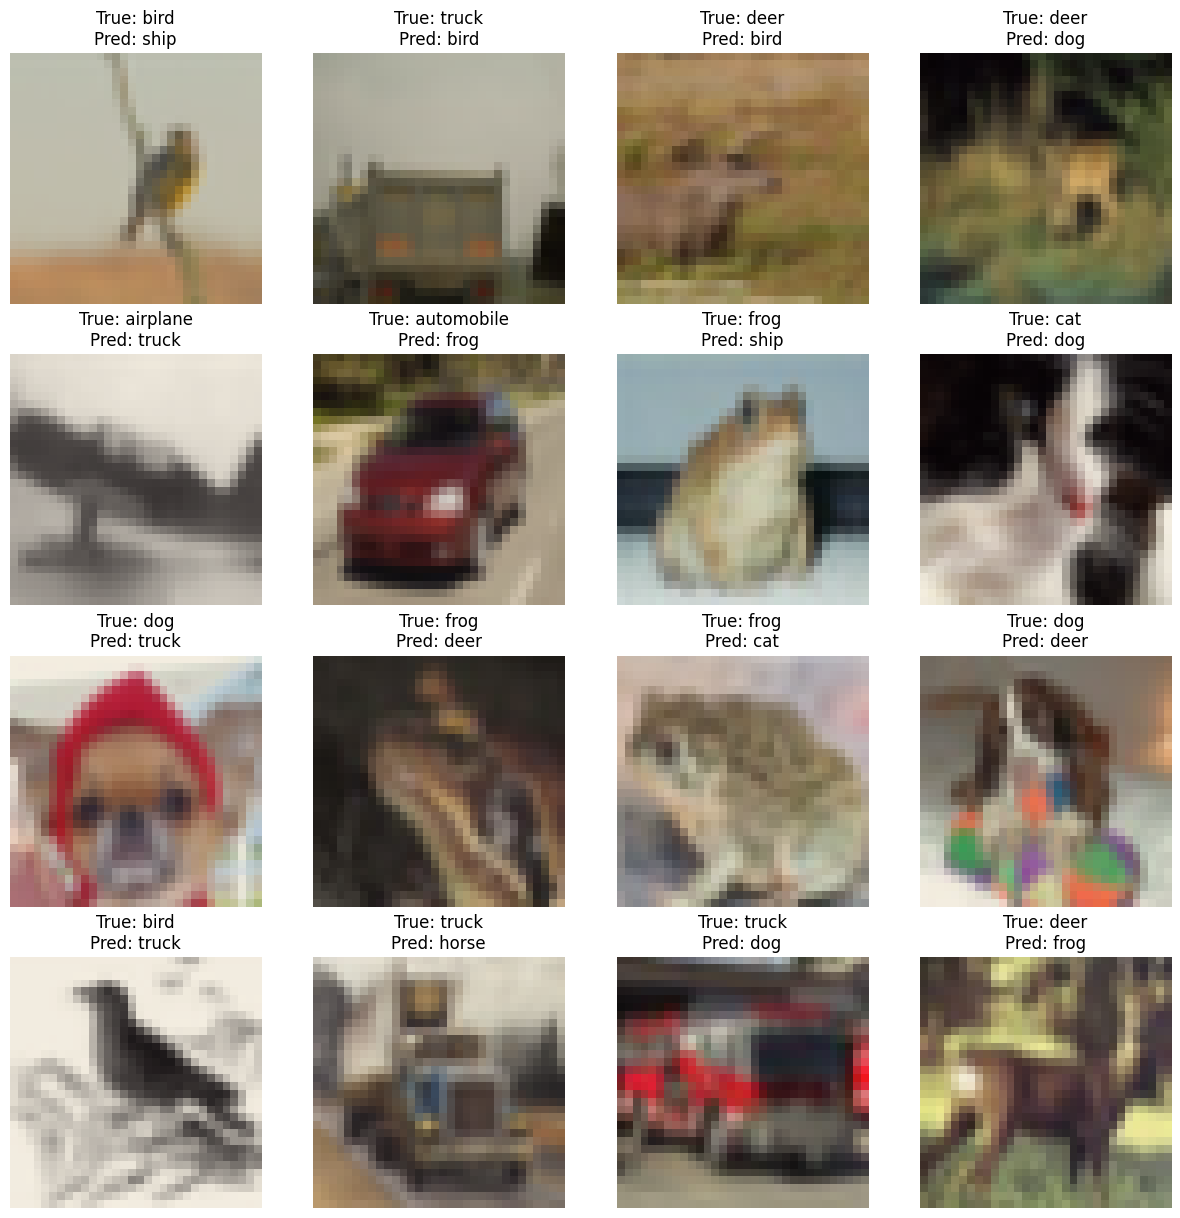

In [ ]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()

Hasta el momento es la combinación de parámetros que mejor loss y otras métricas ha obtenido, en este caso lo que se hizo fue conservar el img_size de 32x32 de las imágenes, diminuir el patch_size y dividir lo otros parámetros para tener un modelo que consuma menos recursos al entrenarse y sea más coherente con el tamaño de CIFAR10.

# Modelo 6 (prueba): como el 5 pero con img_resize
- Transform Resize: 32x32 -> 64x64


In [ ]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Parámetros del modelo
num_epochs = 3

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 64,   # Tamaño de imágenes de CIFAR10
    patch_size= 4,
    embed_dim= 48,
    num_heads= 4,
    ff_dim= 1024,
    num_layers= 4,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_1 = model_1.to(device)

Parametros del modelo: [Parameter containing:
tensor([[[[ 2.9393e-02,  7.3986e-02,  8.9027e-02, -2.9025e-02],
          [ 4.2747e-02, -1.4419e-01,  1.2166e-01, -8.4681e-02],
          [ 2.7777e-02,  8.8096e-02,  1.4289e-01,  1.1206e-01],
          [ 3.3656e-03,  1.0487e-01,  3.9429e-02, -2.5206e-02]],

         [[ 3.2440e-02,  1.4041e-01, -1.0460e-01,  1.0068e-01],
          [-7.8966e-02,  1.3675e-01,  1.4418e-01, -1.3207e-01],
          [ 1.6770e-02,  6.7333e-03,  5.2139e-02,  4.3597e-02],
          [-1.3406e-01,  1.0715e-01,  1.0977e-01, -7.6222e-02]],

         [[ 6.3257e-02,  1.3498e-01, -1.1513e-01,  3.1038e-03],
          [-3.0318e-02, -9.6997e-02, -1.0535e-01, -7.3802e-02],
          [-4.4230e-03, -1.0085e-02, -4.2268e-02, -7.8438e-02],
          [ 5.1886e-02, -5.6999e-02, -1.9590e-02, -2.6588e-02]]],


        [[[-3.6927e-02,  9.5685e-02, -4.5294e-04,  5.5823e-02],
          [-5.6603e-02,  7.7945e-02,  7.2549e-02, -3.3826e-02],
          [-5.1490e-02,  1.2722e-01,  1.1482e-04, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 0.45 millones


In [ ]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 2.09424: 100%|██████████| 98/98 [01:56<00:00,  1.19s/it]


In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)

100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.21
Precision: 0.18
Recall: 0.21
F1 score: 0.18


  0%|          | 0/20 [00:00<?, ?it/s]


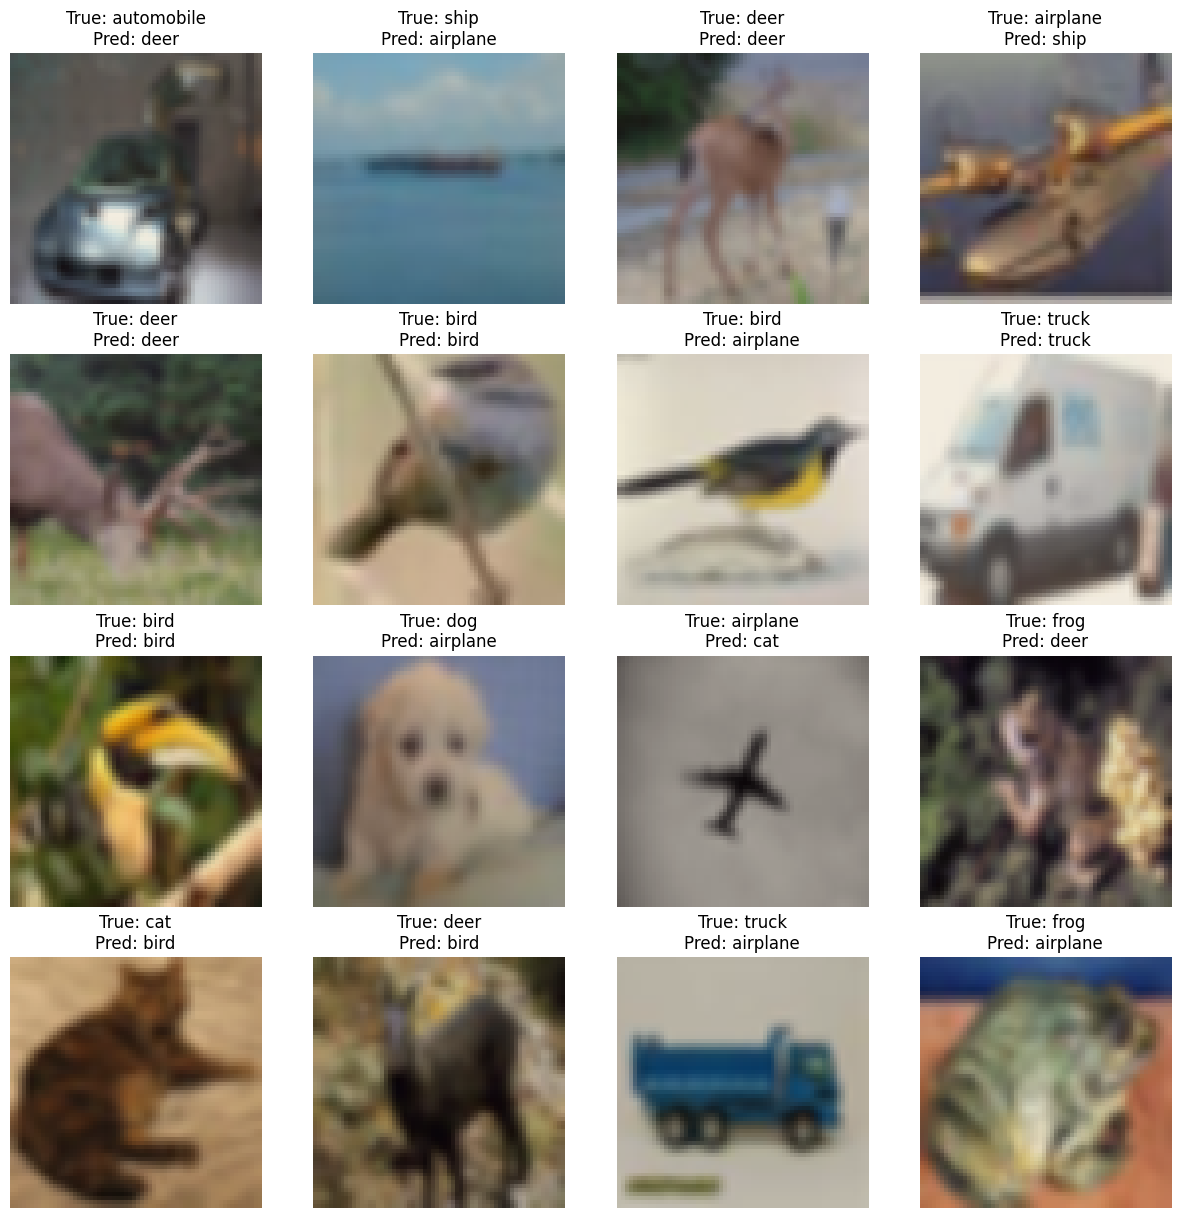

In [ ]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()

La métricas han empeorado levemente respecto al modelo 5 pero sin transforms.Resize, que en este modelo se lo llevó a 64x64 en lugar de 32x32.

# Modelo 7 (prueba): disminución de los parámetros
- patch_size: 4 -> 2
- embed_dim: 48 -> 12
- ff_dim: 1024 -> 256

In [ ]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Parámetros del modelo
num_epochs = 3

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 32,   # Tamaño de imágenes de CIFAR10
    patch_size= 2,
    embed_dim= 12,
    num_heads= 4,
    ff_dim= 256,
    num_layers= 4,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model_1 = model_1.to(device)

Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0354, -0.2764],
          [ 0.2790, -0.2487]],

         [[ 0.1558, -0.0309],
          [-0.0761,  0.2660]],

         [[ 0.0296,  0.1029],
          [ 0.0901, -0.2623]]],


        [[[-0.2603, -0.0370],
          [ 0.1921,  0.2748]],

         [[ 0.1512, -0.2666],
          [ 0.1034, -0.1584]],

         [[-0.2787, -0.0658],
          [-0.0900, -0.1575]]],


        [[[ 0.2366, -0.1205],
          [ 0.1396,  0.2021]],

         [[ 0.1763,  0.0029],
          [-0.0017, -0.0654]],

         [[ 0.0446,  0.0346],
          [-0.2525, -0.1158]]],


        [[[-0.0166,  0.1588],
          [-0.0225,  0.1344]],

         [[-0.0298,  0.0081],
          [ 0.2581, -0.1957]],

         [[-0.1749,  0.2631],
          [ 0.1542, -0.2417]]],


        [[[-0.0064, -0.2271],
          [-0.1582,  0.2225]],

         [[ 0.2305,  0.0251],
          [ 0.0240,  0.1498]],

         [[ 0.2656, -0.1933],
          [ 0.0659,  0.2410]]],


        [[[-0.

In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 0.03 millones


In [ ]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 2.11579: 100%|██████████| 98/98 [01:40<00:00,  1.03s/it]


In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)

100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.20
Precision: 0.20
Recall: 0.20
F1 score: 0.17


  0%|          | 0/20 [00:01<?, ?it/s]


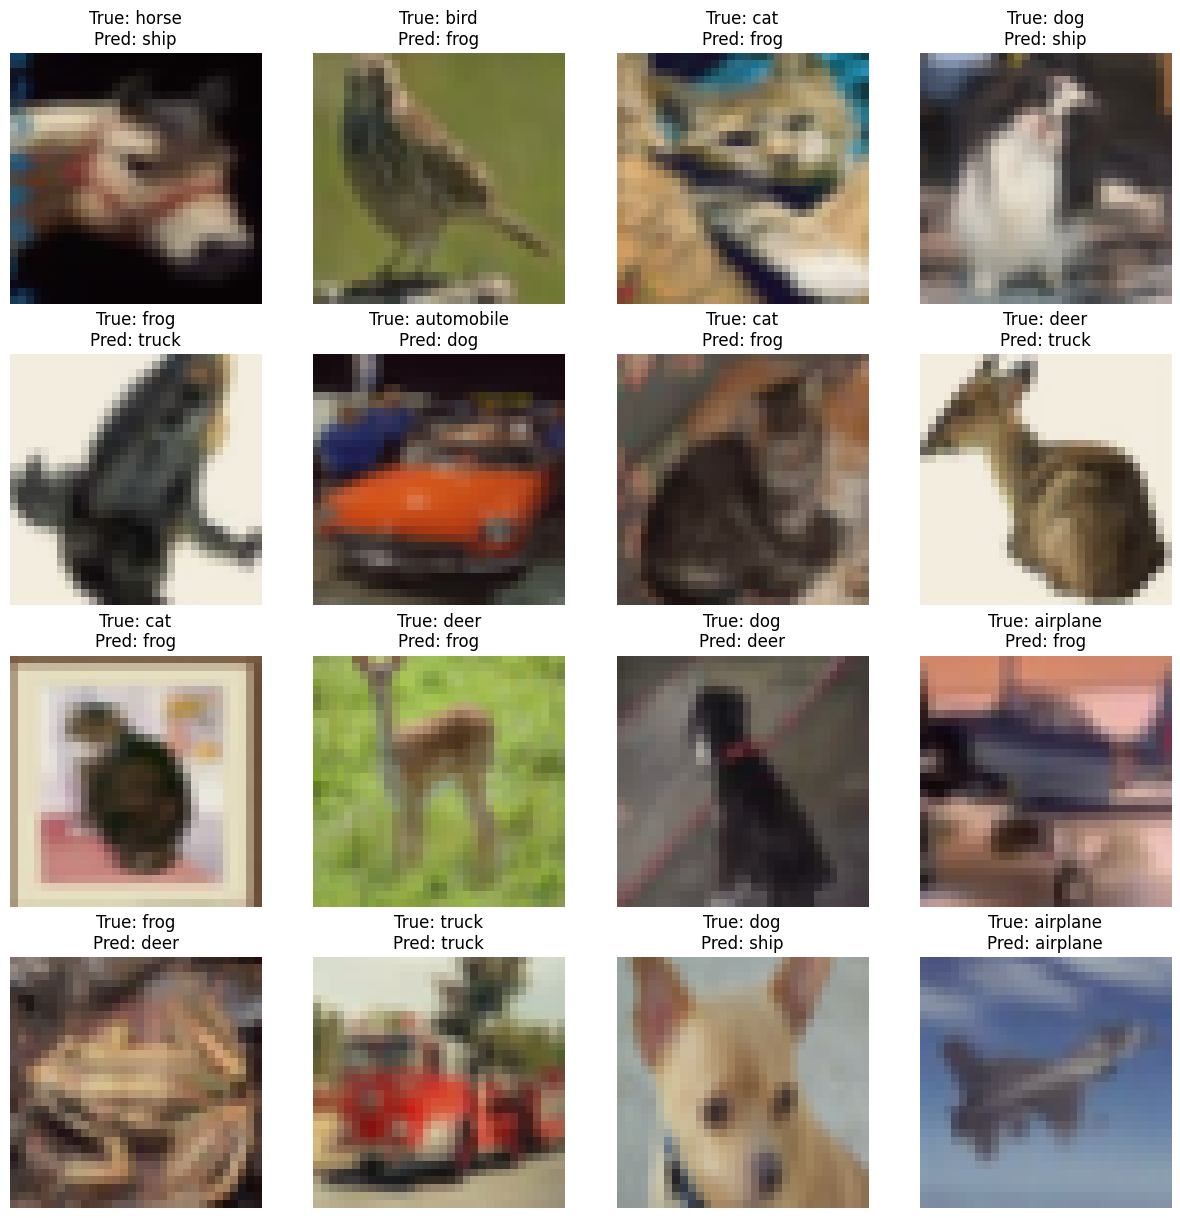

In [ ]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()

Se usó el tamaño original de la imagen pero con un patch_size menor, de 2, pero los resultados no mejoraron respecto al modelo 5.

# Modelo 5 - 10 epochs

Siendo este el modelo con mejores métricas que se obtuvo, se va a entrenar por 10 epochs para tener un valor mejor en los las métricas, luego se va a realizar este mismo modedo pero con data augmentation para comparar los resultados.

In [20]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
# Parámetros del modelo
num_epochs = 10

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 32,   # Tamaño de imágenes de CIFAR10
    patch_size= 4,
    embed_dim= 48,
    num_heads= 4,
    ff_dim= 1024,
    num_layers= 4,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_1 = model_1.to(device)


try:
    model = torch.compile(model_1)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0178, -0.1437,  0.0618,  0.1030],
          [-0.1268, -0.1392, -0.0658,  0.0115],
          [ 0.0161, -0.0971,  0.0320,  0.1115],
          [-0.1191,  0.0509, -0.1067, -0.0375]],

         [[ 0.0821, -0.1083,  0.0195,  0.0839],
          [-0.0602,  0.1097, -0.0997, -0.0542],
          [-0.0839, -0.1139,  0.0271, -0.1204],
          [ 0.0203, -0.0208,  0.1119,  0.1263]],

         [[ 0.0676, -0.0261, -0.1014, -0.0546],
          [ 0.1230, -0.0367, -0.1412, -0.0158],
          [ 0.0508,  0.0363,  0.1032,  0.0122],
          [ 0.0675,  0.0226,  0.0076,  0.0707]]],


        [[[-0.0875,  0.0340,  0.0832, -0.1261],
          [-0.1135,  0.0747,  0.0079, -0.0162],
          [ 0.0668,  0.0372, -0.0436,  0.0034],
          [-0.0301, -0.0826, -0.1107,  0.1200]],

         [[-0.0658, -0.0035, -0.1332, -0.0032],
          [-0.0990, -0.1396, -0.0585,  0.0546],
          [-0.0723, -0.1324, -0.1187, -0.1358],
          [-0.0096, -0.0560,  0.

In [22]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 0.44 millones


In [23]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 1.46872: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]


In [24]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)

100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


In [25]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.49
Precision: 0.49
Recall: 0.49
F1 score: 0.48


  0%|          | 0/20 [00:00<?, ?it/s]


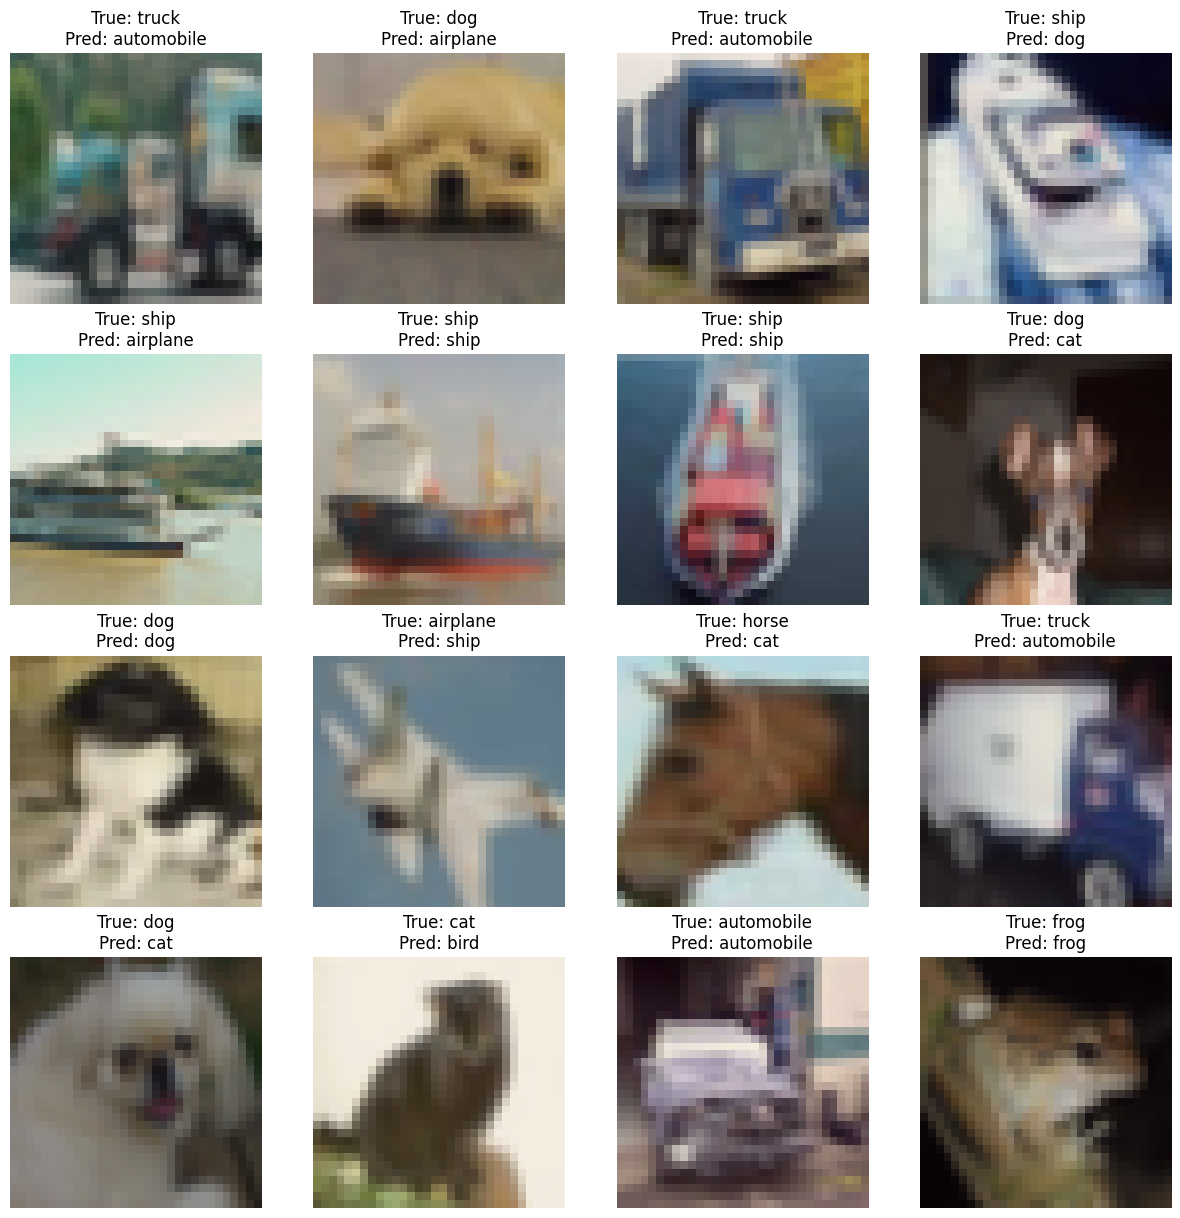

In [26]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()

Se observa que las métricas mejoraron considerablemente, y si se siguiera entrenando estas mejorarían aún más, pero por limitaciones de cómputo solo se hizo durante 10 epochs.

# Modelo 5 - 10 epochs - Data augmentation
- transforms.ColorJitter
- transforms.RandomRotation

In [27]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
# Parámetros del modelo
num_epochs = 10

# Otros params:
# embed_dim= [768, 1024, 1280]
# num_heads= [12, 16, 16]
# ff_dim = [3072, 4096, 5120]
# num_layers= [12, 24, 32]
# params = [86M, 307M, 632M]

model_1 = VisionTransformer(
    img_size= 32,   # Tamaño de imágenes de CIFAR10
    patch_size= 4,
    embed_dim= 48,
    num_heads= 4,
    ff_dim= 1024,
    num_layers= 4,
    dropout= 0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_1.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_1 = model_1.to(device)


try:
    model = torch.compile(model_1)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0593,  0.1415,  0.0903,  0.0155],
          [-0.1276, -0.0604,  0.0794, -0.1395],
          [-0.1166, -0.0900,  0.0999,  0.0643],
          [-0.1007, -0.1081,  0.0634, -0.0294]],

         [[ 0.0747, -0.0776,  0.0350, -0.0248],
          [ 0.0949, -0.0514,  0.0174, -0.0488],
          [-0.0891,  0.1417, -0.0342,  0.0071],
          [ 0.0860, -0.0429,  0.0747,  0.0111]],

         [[ 0.0356, -0.0688,  0.1142, -0.1063],
          [-0.0135,  0.0757,  0.1039,  0.1417],
          [ 0.0867, -0.0916, -0.0980,  0.0353],
          [-0.0476, -0.0183,  0.0670,  0.1157]]],


        [[[ 0.0340,  0.0839,  0.0064,  0.1167],
          [ 0.1379,  0.1155, -0.0155, -0.0051],
          [-0.0312,  0.1000,  0.1208, -0.1119],
          [-0.1344,  0.0358, -0.0322, -0.1190]],

         [[-0.0136, -0.0863,  0.0279,  0.0166],
          [-0.1165,  0.0074, -0.0114, -0.0781],
          [-0.0182, -0.0948,  0.0420, -0.0698],
          [-0.1144, -0.1176, -0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [29]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_1)))

Número de parámetros: 0.44 millones


In [30]:
trainer = Trainer(model_1, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

loss 1.51224: 100%|██████████| 98/98 [01:35<00:00,  1.02it/s]


In [33]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_1, test_loader)

100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


In [34]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.43
Precision: 0.43
Recall: 0.43
F1 score: 0.42


  0%|          | 0/20 [00:00<?, ?it/s]


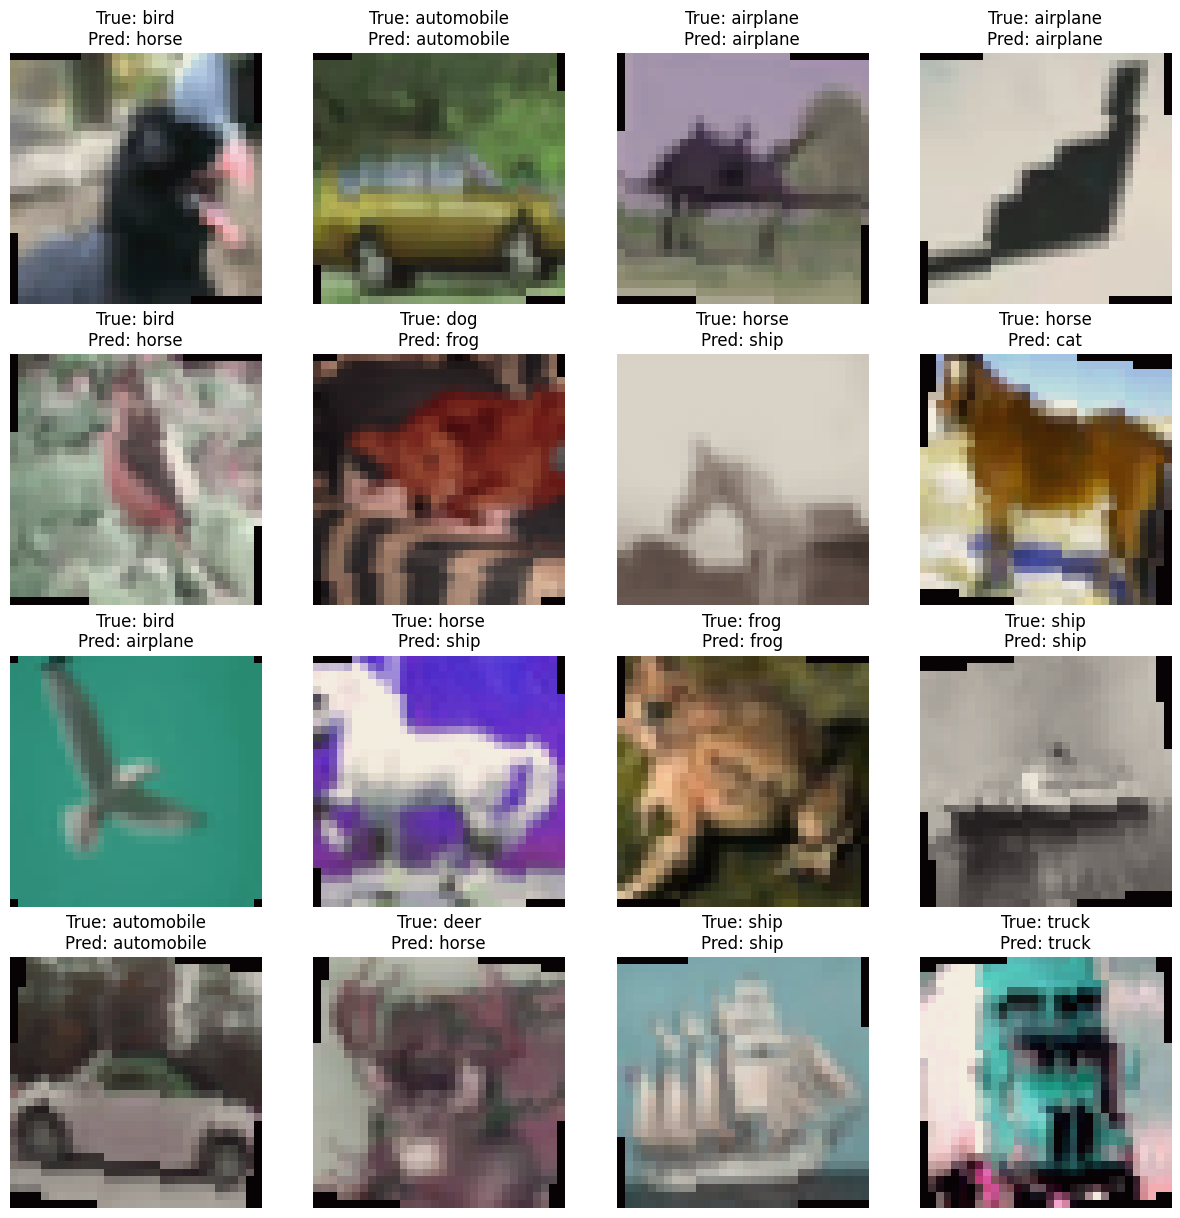

In [35]:
visualize_classification(model_1, test_loader, class_names, num_images=16)
plt.show()

Se observa que se tuvieron buenas métricas al usar data augmentation considerando una variación en los colores al tratarse de imágenes a color y de la rotación, pero para 10 epochs, no se vieron métricas mayores que en el caso de sin estas transforms.